In [3]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
from sklearn.utils.fixes import parse_version, sp_version
# This is line is to avoid incompatibility if older SciPy version.
# You should use `solver="highs"` with recent version of SciPy.
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

# Building the Model

In [4]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import QuantileRegressor

class QuantileTreeRegressor:
    def __init__(self, quantile=0.75, max_depth=10):
        self.quantile = quantile
        self.max_depth = max_depth
        self.tree = []

    def fit(self, X, y):
        self.tree = self._fit_tree(X, y, depth=0)

    def _fit_tree(self, X, y, depth, struct = 'begin', final = 0):

        if depth == self.max_depth or len(np.unique(y)) == 1:
            #solver = 'some_solver'  # Define the appropriate solver here
            #qr = QuantileRegressor(quantile=self.quantile, alpha=0, solver=solver)
            #qr.fit(X, y)
            #qr.predict(X)
            final = 1
            return "done"

        split_feature, split_threshold, loss, left_model, right_model = self._find_best_split(X, y)

        ##split data
        left_mask = X[:, split_feature] <= split_threshold
        right_mask = ~left_mask

        left_tree = self._fit_tree(X[left_mask], y[left_mask], depth = depth + 1, struct = 'left')
        right_tree = self._fit_tree(X[right_mask], y[right_mask], depth = depth + 1, struct = 'right')


        return {'depth': depth, 'final':final, 'struct': struct,
                'feature': split_feature, 'threshold': split_threshold,
                'loss': loss, 'left': left_tree, 'right': right_tree,
                'left_model': left_model, 'right_model': right_model}

    def _find_best_split(self, X, y):
        best_split_feature = None
        best_split_threshold = None
        best_loss = float('inf')

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            #X_ = X[:, feature]
            #y_ =  y[X_]
            #qr.fit(X_,y_)
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                # Ensure both left and right have at least 1 sample
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue

                left_predict = self._predict_quantile(X[left_mask],y[left_mask])
                left_residuals = y[left_mask] - left_predict[0]
                left_model = left_predict[1]

                right_predict = self._predict_quantile(X[right_mask],y[right_mask])
                right_residuals = y[right_mask] - right_predict[0]
                right_model = right_predict[1]

                left_loss = self._custom_loss(left_residuals, self.quantile)
                right_loss = self._custom_loss(right_residuals, self.quantile)
                total_loss = left_loss + right_loss

                if total_loss < best_loss:
                    best_loss = total_loss
                    best_split_feature = feature
                    best_split_threshold = threshold
                    best_left_model = left_model
                    best_right_model = right_model

        return best_split_feature, best_split_threshold, best_loss, best_left_model, best_right_model

    def _custom_loss(self, residuals, tau):
        for residual in residuals:
            if residual <= 0:
                loss = tau*residual
            else:
                loss = (1 - tau)*residual
        # Define your custom loss function here
        # For example, you can modify the pinball loss or use a different loss function
        return np.sum(np.abs(residuals))#tau * np.sum(np.abs(residuals)) + (1 - tau) * np.sum(np.abs(residuals))

    def _predict_quantile(self, X,y):
        qr = QuantileRegressor(quantile=self.quantile, alpha=0, solver=solver)
        qr.fit(X, y)
        return qr.predict(X) , qr


    def predict(self, X):
        if self.tree is None:
            raise ValueError("Tree is not trained. Call fit() to train the tree.")

        predictions = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            predictions[i] = self._predict_tree(X[i], self.tree[0])

        return predictions

    def predict(self, X):
        return np.array([self._predict_tree(x, self.tree) for x in X])

    def _predict_tree(self, x, node):
        if node['depth'] == self.max_depth - 1:
            if x[node['feature']] <= node['threshold']:
                return node['left_model'].predict([x])
            else:
                return node['right_model'].predict([x])

            #return node  # Leaf node, return quantile prediction
        else:
            if x[node['feature']] <= node['threshold']:
                return self._predict_tree(x, node['left'])
            else:
                return self._predict_tree(x, node['right'])





# Testing the Model on simulated data

In [5]:
# Simulate data
np.random.seed(42)
X = np.random.rand(100, 1) * 1  # Feature
y = 3 * X[:, 0] + np.random.normal(0, 1, size=100)  # Target (with some noise)
y = y**2
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Instantiate and fit the model
quantile = 0.5
model = QuantileTreeRegressor(quantile=quantile, max_depth=2)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

In [7]:
# View basic tree with 1 feature
def print_tree(node, depth=0, feature_name="X", side="Root"):
    indent = "    " * depth
    prefix = "├─ " if side == "Left" else "└─ "
    if isinstance(node, (str)):
        #print ('done')#(f"{indent}{prefix} Predict: {node:.2f}")
        pass
    else:
        print(f"{indent}{prefix}{feature_name} <= {node['threshold']:.2f}, Loss: {node['loss']:.2f}")
        print_tree(node['left'], depth + 1, feature_name=feature_name, side="Left")
        print_tree(node['right'], depth + 1, feature_name=feature_name, side="Right")



In [8]:
# Print the tree structure
print_tree(model.tree)

└─ X <= 0.60, Loss: 147.24
    ├─ X <= 0.52, Loss: 62.61
    └─ X <= 0.95, Loss: 65.77


Mean Absolute Error: 2.450724712587463
Mean Squared Error: 16.846598832031944


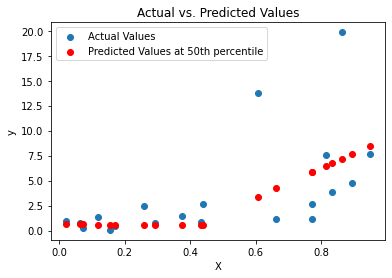

In [9]:
# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae}")

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

#error = (quantile * np.sum(np.abs(y_test-predictions)) + (1 - quantile) * np.sum(np.abs(y_test-predictions)))/len(y_test)
#print(f"Error: {error}")


# Visualize predictions
plt.scatter(X_test, y_test, label="Actual Values")
plt.scatter(X_test, predictions, label="Predicted Values at 50th percentile", color='r')
plt.xlabel("X")
plt.ylabel("y")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()


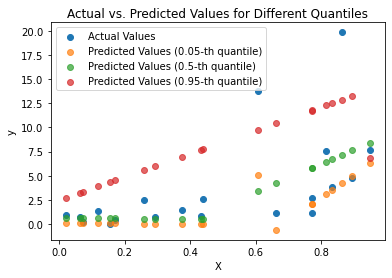

In [11]:
# Define the quantiles you want to consider
quantiles = [0.05, 0.5, 0.95]

# Dictionary to store predictions for each quantile
quantile_predictions = {}

# Iterate over quantiles
for quantile in quantiles:
    # Instantiate and fit the model
    model = QuantileTreeRegressor(quantile=quantile, max_depth=2)
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)
    
    # Store predictions in the dictionary
    quantile_predictions[quantile] = predictions

    # Evaluate the model (you can adjust this part based on your needs)
    mae = mean_absolute_error(y_test, predictions)
    print(f'Mean Squared Error for {quantile}-th quantile: {mse}')


# Plot the actual values
plt.scatter(X_test, y_test, label="Actual Values", marker='o')#, color='blue'

# Plot predictions for each quantile
for quantile, predictions in quantile_predictions.items():
    plt.scatter(X_test, predictions, label=f"Predicted Values ({quantile}-th quantile)", alpha=0.7)

plt.xlabel("X")
plt.ylabel("y")
plt.title("Actual vs. Predicted Values for Different Quantiles")
plt.legend()
plt.show()

## Comparison with quantile regression across different quantiles

In [12]:
quantiles = np.arange(0.05, 1.0, 0.05)  # from 0.5 to 0.95 in steps of 0.05

# Dictionary to store evaluation metrics for each quantile
evaluation_metrics = {'quantile': [], 'MAE_qr': [], 'MSE_qr': [], 'MAE_qtr': [], 'MSE_qtr': []}

# Dictionary to store predictions for each quantile
quantile_predictions = {}

In [13]:
# Iterate over quantiles
for quantile in quantiles:
    # Instantiate and fit QuantileTreeRegressor
    qtr_model = QuantileTreeRegressor(quantile=quantile, max_depth=2)
    qtr_model.fit(X_train, y_train)

    # Instantiate and fit QuantileRegressor
    quantile_regressor_model = QuantileRegressor(quantile=quantile, alpha=0, solver=solver)
    quantile_regressor_model.fit(X_train, y_train)

    # Make predictions
    predictions_qtr = qtr_model.predict(X_test)
    predictions_qr = quantile_regressor_model.predict(X_test)

    # Record evaluation metrics
    mae_qtr = mean_absolute_error(y_test, predictions_qtr)
    mse_qtr = mean_squared_error(y_test, predictions_qtr)
    mae_qr = mean_absolute_error(y_test, predictions_qr)
    mse_qr = mean_squared_error(y_test, predictions_qr)

    # Store evaluation metrics in the dictionary
    evaluation_metrics['quantile'].append(quantile)
    evaluation_metrics['MAE_qr'].append(mae_qr)
    evaluation_metrics['MSE_qr'].append(mse_qr)
    evaluation_metrics['MAE_qtr'].append(mae_qtr)
    evaluation_metrics['MSE_qtr'].append(mse_qtr)

    # Store predictions in the dictionary
    quantile_predictions[quantile] = {'qtr': predictions_qtr, 'qr': predictions_qr}

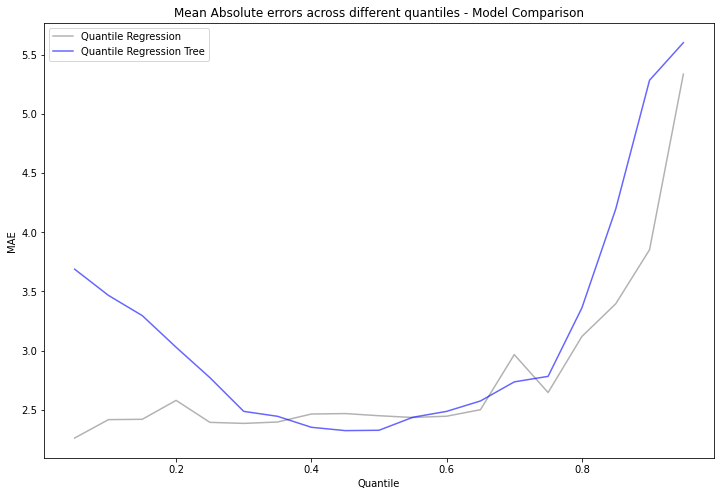

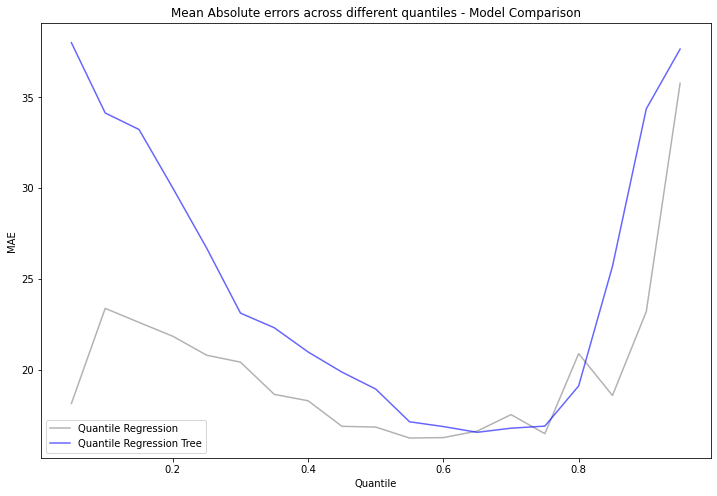

In [14]:
# Scatter plot for Actual vs. Predicted Values
plt.figure(figsize=(12, 8))
plt.plot(quantiles, evaluation_metrics['MAE_qtr'], label="Quantile Regression", color='gray', alpha=0.6)
plt.plot(quantiles, evaluation_metrics['MAE_qr'], label="Quantile Regression Tree", color='blue', alpha=0.6)
plt.xlabel("Quantile")
plt.ylabel("MAE")
plt.title("Mean Absolute errors across different quantiles - Model Comparison")
plt.legend()
plt.show()

# Scatter plot for Actual vs. Predicted Values
plt.figure(figsize=(12, 8))
plt.plot(quantiles, evaluation_metrics['MSE_qtr'], label="Quantile Regression", color='gray', alpha=0.6)
plt.plot(quantiles, evaluation_metrics['MSE_qr'], label="Quantile Regression Tree", color='blue', alpha=0.6)
plt.xlabel("Quantile")
plt.ylabel("MAE")
plt.title("Mean Absolute errors across different quantiles - Model Comparison")
plt.legend()
plt.show()

## Comparison with other models

In [15]:
# Initialize and train the Quantile Tree Regressor
quantile = 0.5
qtr_model = QuantileTreeRegressor(quantile=quantile, max_depth=2)
qtr_model.fit(X_train, y_train)
predictions = qtr_model.predict(X_test)

In [16]:
# Initialize and train other comparison models
linear_model = LinearRegression()
decision_tree_model = DecisionTreeRegressor(random_state=42)
quantile_regressor_model = QuantileRegressor(quantile=quantile, alpha=0, solver=solver)

linear_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)
quantile_regressor_model.fit(X_train, y_train)

QuantileRegressor(alpha=0, solver='highs')

In [17]:
# Make predictions using the comparison models
linear_predictions = linear_model.predict(X_test)
decision_tree_predictions = decision_tree_model.predict(X_test)
quantile_regressor_predictions = quantile_regressor_model.predict(X_test)

In [18]:
# Calculate MAE and MSE for all models
mae_values = [
    mean_absolute_error(y_test, predictions),
    mean_absolute_error(y_test, quantile_regressor_predictions),
    mean_absolute_error(y_test, linear_predictions),
    mean_absolute_error(y_test, decision_tree_predictions)
    
]

mse_values = [
    mean_squared_error(y_test, predictions),
    mean_squared_error(y_test, quantile_regressor_predictions),
    mean_squared_error(y_test, linear_predictions),
    mean_squared_error(y_test, decision_tree_predictions)
    
]

In [19]:
print(mae_values)

[2.450724712587463, 2.3278908694859815, 2.4858739467160853, 2.7696553353068265]


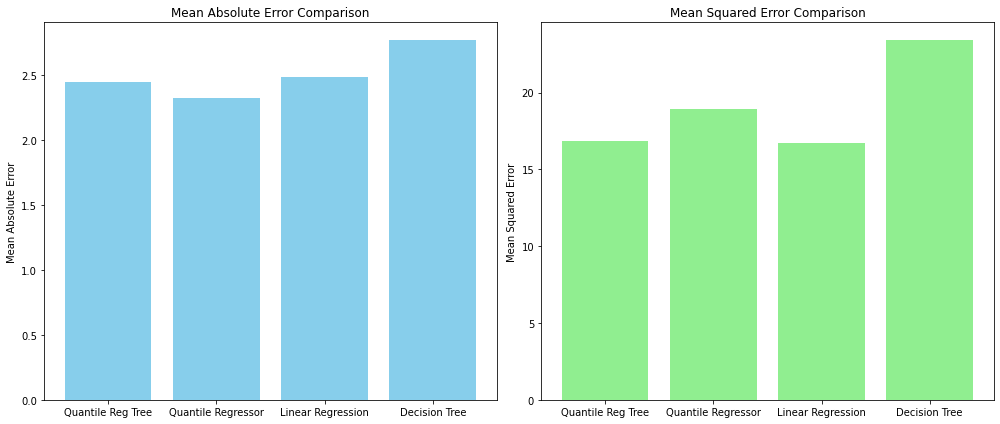

In [20]:
# Bar plot for MAE and MSE comparison
models = ["Quantile Reg Tree", "Quantile Regressor","Linear Regression", "Decision Tree"]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].bar(models, mae_values, color='skyblue')
axes[0].set_title("Mean Absolute Error Comparison")
axes[0].set_ylabel("Mean Absolute Error")

axes[1].bar(models, mse_values, color='lightgreen')
axes[1].set_title("Mean Squared Error Comparison")
axes[1].set_ylabel("Mean Squared Error")

plt.tight_layout()
plt.show()

## Boston Housing Dataset

In [21]:
import os
import pandas as pd
os.getcwd()

'/nfs/home/jokafor/ML2'

In [22]:
data_dir = "BostonHousing.csv"

In [23]:
data = pd.read_csv(data_dir)
data =  data.dropna()

In [24]:
data.shape

(501, 14)

In [25]:
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Data Split

In [26]:
X = data.drop('medv', axis=1).to_numpy()  # medv = target_column 
y = data[['medv']].values.ravel()

In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



### Building trees for different quantiles

In [28]:
# Instantiate and fit the model
quantile = 0.05
model = QuantileTreeRegressor(quantile=quantile, max_depth=2)
model.fit(X_train, y_train)

In [29]:
model.tree

{'depth': 0,
 'final': 0,
 'struct': 'begin',
 'feature': 5,
 'threshold': 7.016,
 'loss': 1663.9898020502133,
 'left': {'depth': 1,
  'final': 0,
  'struct': 'left',
  'feature': 7,
  'threshold': 2.3534,
  'loss': 1259.456448732837,
  'left': 'done',
  'right': 'done',
  'left_model': QuantileRegressor(alpha=0, quantile=0.05, solver='highs'),
  'right_model': QuantileRegressor(alpha=0, quantile=0.05, solver='highs')},
 'right': {'depth': 1,
  'final': 0,
  'struct': 'right',
  'feature': 5,
  'threshold': 7.416,
  'loss': 70.29465818596245,
  'left': 'done',
  'right': 'done',
  'left_model': QuantileRegressor(alpha=0, quantile=0.05, solver='highs'),
  'right_model': QuantileRegressor(alpha=0, quantile=0.05, solver='highs')},
 'left_model': QuantileRegressor(alpha=0, quantile=0.05, solver='highs'),
 'right_model': QuantileRegressor(alpha=0, quantile=0.05, solver='highs')}

In [30]:
quantile = 0.5
model_1 = QuantileTreeRegressor(quantile=quantile, max_depth=2)
model_1.fit(X_train, y_train)
model_1.tree

{'depth': 0,
 'final': 0,
 'struct': 'begin',
 'feature': 5,
 'threshold': 6.54,
 'loss': 948.2107471024401,
 'left': {'depth': 1,
  'final': 0,
  'struct': 'left',
  'feature': 7,
  'threshold': 1.3861,
  'loss': 497.1022043155031,
  'left': 'done',
  'right': 'done',
  'left_model': QuantileRegressor(alpha=0, solver='highs'),
  'right_model': QuantileRegressor(alpha=0, solver='highs')},
 'right': {'depth': 1,
  'final': 0,
  'struct': 'right',
  'feature': 7,
  'threshold': 1.9047,
  'loss': 236.51335039296077,
  'left': 'done',
  'right': 'done',
  'left_model': QuantileRegressor(alpha=0, solver='highs'),
  'right_model': QuantileRegressor(alpha=0, solver='highs')},
 'left_model': QuantileRegressor(alpha=0, solver='highs'),
 'right_model': QuantileRegressor(alpha=0, solver='highs')}

In [31]:
quantile = 0.95
model_2 = QuantileTreeRegressor(quantile=quantile, max_depth=2)
model_2.fit(X_train, y_train)
model_2.tree

{'depth': 0,
 'final': 0,
 'struct': 'begin',
 'feature': 12,
 'threshold': 9.38,
 'loss': 2071.3999407682986,
 'left': {'depth': 1,
  'final': 0,
  'struct': 'left',
  'feature': 9,
  'threshold': 403.0,
  'loss': 565.6032374180929,
  'left': 'done',
  'right': 'done',
  'left_model': QuantileRegressor(alpha=0, quantile=0.95, solver='highs'),
  'right_model': QuantileRegressor(alpha=0, quantile=0.95, solver='highs')},
 'right': {'depth': 1,
  'final': 0,
  'struct': 'right',
  'feature': 0,
  'threshold': 14.4208,
  'loss': 1058.6000033682867,
  'left': 'done',
  'right': 'done',
  'left_model': QuantileRegressor(alpha=0, quantile=0.95, solver='highs'),
  'right_model': QuantileRegressor(alpha=0, quantile=0.95, solver='highs')},
 'left_model': QuantileRegressor(alpha=0, quantile=0.95, solver='highs'),
 'right_model': QuantileRegressor(alpha=0, quantile=0.95, solver='highs')}

## Model Comparisons

### Comparsion with quantile regression

In [45]:
quantiles = np.arange(0.05, 1.0, 0.1)  # from 0.5 to 0.95 in steps of 0.1

# Dictionary to store evaluation metrics for each quantile
evaluation_metrics = {'quantile': [], 'MAE_qr': [], 'MSE_qr': [], 'MAE_qtr': [], 'MSE_qtr': []}

# Dictionary to store predictions for each quantile
quantile_predictions = {}

In [46]:
# Iterate over quantiles
for quantile in quantiles:
    # Instantiate and fit QuantileTreeRegressor
    qtr_model = QuantileTreeRegressor(quantile=quantile, max_depth=2)
    qtr_model.fit(X_train, y_train)

    # Instantiate and fit QuantileRegressor
    quantile_regressor_model = QuantileRegressor(quantile=quantile, alpha=0, solver=solver)
    quantile_regressor_model.fit(X_train, y_train)

    # Make predictions
    predictions_qtr = qtr_model.predict(X_test)
    predictions_qr = quantile_regressor_model.predict(X_test)

    # Record evaluation metrics
    mae_qtr = mean_absolute_error(y_test, predictions_qtr)
    mse_qtr = mean_squared_error(y_test, predictions_qtr)
    mae_qr = mean_absolute_error(y_test, predictions_qr)
    mse_qr = mean_squared_error(y_test, predictions_qr)

    # Store evaluation metrics in the dictionary
    evaluation_metrics['quantile'].append(quantile)
    evaluation_metrics['MAE_qr'].append(mae_qr)
    evaluation_metrics['MSE_qr'].append(mse_qr)
    evaluation_metrics['MAE_qtr'].append(mae_qtr)
    evaluation_metrics['MSE_qtr'].append(mse_qtr)

    # Store predictions in the dictionary
    quantile_predictions[quantile] = {'qtr': predictions_qtr, 'qr': predictions_qr}

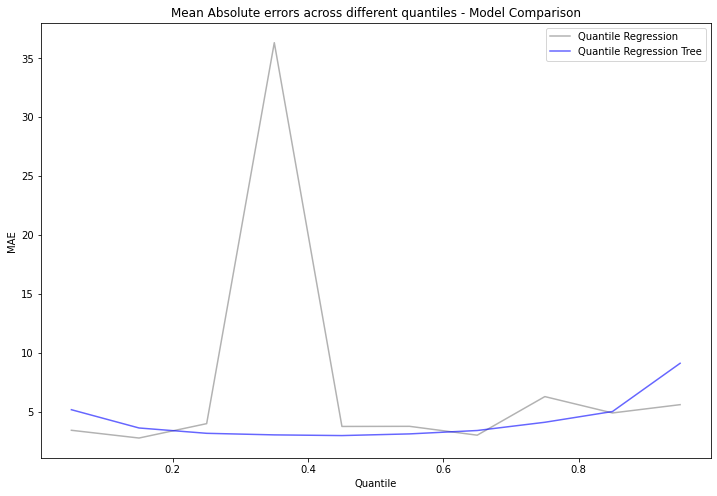

In [47]:
# Scatter plot for Actual vs. Predicted Values
plt.figure(figsize=(12, 8))
plt.plot(quantiles, evaluation_metrics['MAE_qtr'], label="Quantile Regression", color='gray', alpha=0.6)
plt.plot(quantiles, evaluation_metrics['MAE_qr'], label="Quantile Regression Tree", color='blue', alpha=0.6)
plt.xlabel("Quantile")
plt.ylabel("MAE")
plt.title("Mean Absolute errors across different quantiles - Model Comparison")
plt.legend()
plt.show()

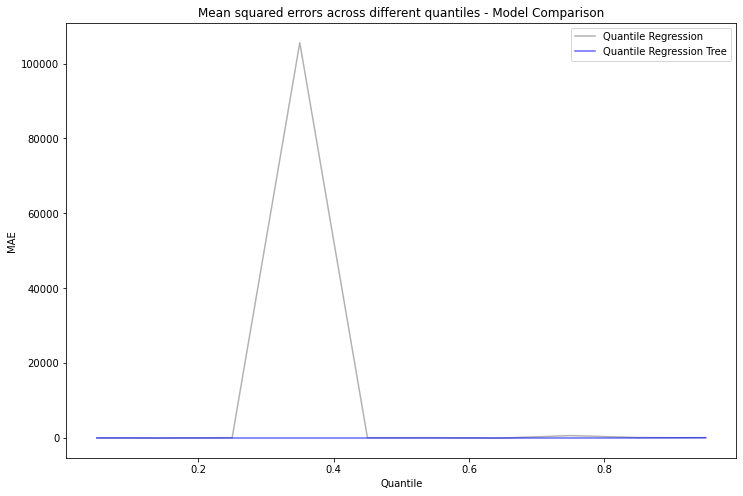

In [49]:
# Scatter plot for Actual vs. Predicted Values
plt.figure(figsize=(12, 8))
plt.plot(quantiles, evaluation_metrics['MSE_qtr'], label="Quantile Regression", color='gray', alpha=0.6)
plt.plot(quantiles, evaluation_metrics['MSE_qr'], label="Quantile Regression Tree", color='blue', alpha=0.6)
plt.xlabel("Quantile")
plt.ylabel("MAE")
plt.title("Mean squared errors across different quantiles - Model Comparison")
plt.legend()
plt.show()

### Comparsion with quantile regression

In [33]:
pred = model_1.predict(X_test)

# Initialize and train other comparison models
linear_model_1 = LinearRegression()
decision_tree_model_1 = DecisionTreeRegressor(random_state=42)
quantile_regressor_model_1 = QuantileRegressor(quantile=quantile, alpha=0, solver=solver)

linear_model_1.fit(X_train, y_train)
decision_tree_model_1.fit(X_train, y_train)
quantile_regressor_model_1.fit(X_train, y_train)

QuantileRegressor(alpha=0, quantile=0.95, solver='highs')

In [ ]:
# Make predictions using the comparison models
linear_predictions = linear_model_1.predict(X_test)
decision_tree_predictions = decision_tree_model_1.predict(X_test)
quantile_regressor_predictions = quantile_regressor_model_1.predict(X_test)

In [ ]:
# Calculate MAE and MSE for all models
mae_values = [
    mean_absolute_error(y_test, pred),
    mean_absolute_error(y_test, quantile_regressor_predictions),
    mean_absolute_error(y_test, linear_predictions),
    mean_absolute_error(y_test, decision_tree_predictions)
    
]

mse_values = [
    mean_squared_error(y_test, pred),
    mean_squared_error(y_test, quantile_regressor_predictions),
    mean_squared_error(y_test, linear_predictions),
    mean_squared_error(y_test, decision_tree_predictions)
    
]

In [ ]:
# Bar plot for MAE and MSE comparison
models = ["Quantile Reg Tree", "Quantile Regressor","Linear Regression", "Decision Tree"]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].bar(models, mae_values, color='skyblue')
axes[0].set_title("Mean Absolute Error Comparison")
axes[0].set_ylabel("Mean Absolute Error")

axes[1].bar(models, mse_values, color='lightgreen')
axes[1].set_title("Mean Squared Error Comparison")
axes[1].set_ylabel("Mean Squared Error")

plt.tight_layout()
plt.show()